# Particle Identification (PID)

ML reco. differentiates particle types as 5 (6) categories as below, regardless of their charge signs.

***0: photon***

***1: electron***

***2: muon***

***3: pion***

***4: proton***

***5: kaon*** (2x2 only)

Particle identification (PID) prediction is one of the results of ML reco. and it is crucial information for any analysis.

In this notebook, we will


 **On the particle level:** 
 
 * Understand PID attributes in `Particles` and `Truth_Particles`. 
 * Construct dataframe with (truth, reco) particle pairs
 * Plot per-particle PID confusion matrix.
 
 **On the interaction level:**
 * Find true `MPV` interaction & matching reco interaction 
 * Define a PID performance metric on the interaction level
 * Build interaction dataframe
 * Project PID performance on true number of primaries, true kinetic energy



# 1. Setup

In [1]:
# Basic boilerplate imports
import numpy as np
import pandas as pd
import yaml, os, sys, re

# Visualization Tools
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import seaborn

from tqdm import tqdm

In [2]:
# Set paths
SOFTWARE_PATH = "/sdf/data/neutrino/software/spine/"
sys.path.insert(0, SOFTWARE_PATH)

In [3]:
pwd

'/sdf/home/d/drielsma/spine_workshop_2024/reconstruction/PID'

In [4]:
# Load anatools config file
cfg = '../../template.cfg'
cfg = yaml.safe_load(open(cfg, 'r'))

In [46]:
# Initialize Anatools manager
from spine.driver import Driver

cfg['io']['reader']['file_keys'] = '/sdf/data/neutrino/public_html/spine_workshop/reco/generic_medium_spine.h5'

driver = Driver(cfg)


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.1.0

$CUDA_VISIBLE_DEVICES=

Configuration processed at: Linux sdfampere039 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {seed: 1721873809}
io:
  reader: {name: hdf5, file_keys: /sdf/data/neutrino/public_html/spine_workshop/reco/generic_medium_spine.h5}
build: {mode: both, units: cm, fragments: false, particles: true, interactions: true}

Will load 1 file(s):
  - /sdf/data/neutrino/public_html/spine_workshop/reco/generic_medium_spine.h5

Total number of entries in the file(s): 256

Total number of entries selected: 256



# 2. Particle-level PID investigation

## 2.1.  Take a look at the PID information in the dataset.

We will take a look at a single image PID information to begin with.

In [6]:
# Get entry number #ENTRY_NUM from HDF5 (when reading from HDF5)
ENTRY_NUM = 1
data = driver.process(entry=ENTRY_NUM)

# Retrieving data structures
reco_particles     = data['reco_particles']
truth_particles    = data['truth_particles']
#interactions       = data['interactions']
#truth_interactions = data['truth_interactions']

Let's take a look at the PID information saved in `particles` and `truth_particles` 

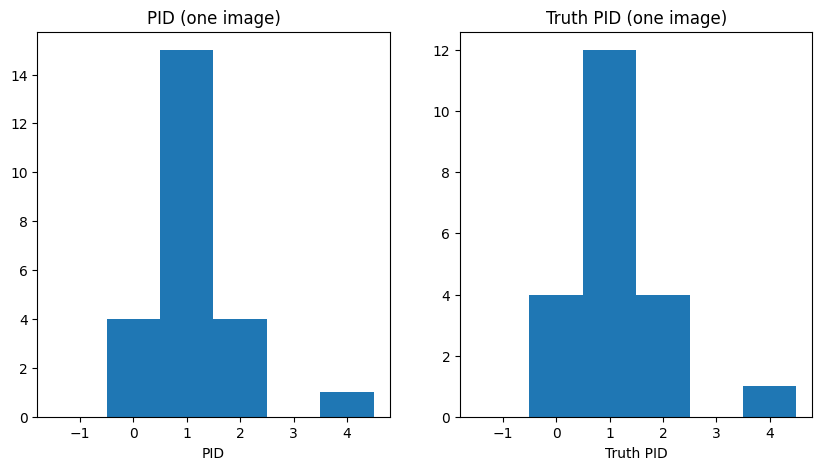

In [7]:
one_img_pid = []
one_img_truth_pid = []

for part in reco_particles:
    one_img_pid.append(part.pid)

for truth_part in truth_particles:
    one_img_truth_pid.append(truth_part.pid)

f, (ax1, ax2) = plt.subplots(1,2)
f.set_figheight(5)
f.set_figwidth(10)
ax1.hist(one_img_pid, np.linspace(-1.5, 4.5, 7))
ax1.set_title("PID (one image)")
ax1.set_xlabel("PID")
ax2.hist(one_img_truth_pid, np.linspace(-1.5, 4.5, 7))
ax2.set_title("Truth PID (one image)")
ax2.set_xlabel("Truth PID")
plt.show()

As expected, the PID in the reconstructed particles are integers between [0, 4]. 

`True PID == -1` would indicate that the PID information is missing for some of the truth particles.


### Exercise 1:

Shall we identify all the creation processes / parent_PID with missing PID information in the entire dataset?

In [8]:
missingPID_creation_processes=[]
missingPID_shape=[]
missingPID_PID=[]
missingPID_parent_PID=[]

for ENTRY_NUM in range(len(driver)):

    data = driver.process(entry=ENTRY_NUM)
    
    truth_particles = data['truth_particles']

    for truth_part in truth_particles:
        if truth_part.pid < 0:
            #print("Image : ", ENTRY_NUM)
            #print("Is primary? : ", truth_part.is_primary)
            missingPID_creation_processes.append(truth_part.creation_process)
            missingPID_shape.append(truth_part.shape)
            missingPID_PID.append(truth_part.pdg_code)
            missingPID_parent_PID.append(truth_part.ancestor_pdg_code)
            
processes, count = np.unique(missingPID_creation_processes, return_counts=True)
shape, shape_count = np.unique(missingPID_shape, return_counts=True)
PID, PID_count = np.unique(missingPID_PID, return_counts=True)
parent_PID, parent_PID_count = np.unique(missingPID_parent_PID, return_counts=True)

print("=== Process names and occurence ===")
for i in range (len(processes)):
    print (processes[i], ", count : ", count[i])
print("\n")

print("=== Shape ===")
for i in range (len(shape)):
    print (shape[i], ", count : ", shape_count[i])
print("\n")

print("=== PID and occurence ===")
for i in range (len(PID)):
    print (PID[i], ", count : ", PID_count[i])
print("\n")

print("=== Ancestor PID and occurence ===")
for i in range (len(parent_PID)):
    print (parent_PID[i], ", count : ", parent_PID_count[i])

=== Process names and occurence ===
muMinusCaptureAtRest , count :  1
nCapture , count :  6
neutronInelastic , count :  51
pi+Inelastic , count :  4
pi-Inelastic , count :  6
protonInelastic , count :  4


=== Shape ===
0 , count :  13
4 , count :  59


=== PID and occurence ===
22 , count :  72


=== Ancestor PID and occurence ===
0 , count :  72


## 2.2.  Particle matching and confusion matrix

With the better understanding of the dataset, we can build PID confusion matrices.
We can attempt a truth-reco matching and confusion matrix building at this point.
Let's define some plotting functions here.

In [9]:
# Get entry number #ENTRY_NUM from HDF5 (when reading from HDF5)
ENTRY_NUM = 1
data = driver.process(entry=ENTRY_NUM)

reco_particles = data['reco_particles']
truth_particles = data['truth_particles']

In [10]:
# function that returns Pandas data structure for particle matching for one image

def fill_particles(particles, truth_particles):

    p_matches = {
        "pred_type" : [],
        "pid_scores": [],
        "is_primary": [],
        "inter_id": [],
        "depo_sum": [],
        "semantic_type": [],
        "true_type": [],
        "true_nu_id": [],
        "true_EDepo": [],
        "true_EInit": [],
        "true_primary": [],
        "true_inter_id": [],
        "true_kinE": [],
    }
    
    for p in particles:
        
        # Check if the particle has a matching truth
        if len(p.match_ids) < 1.:
            continue
        p_matches["pred_type"].append(p.pid)
        p_matches["pid_scores"].append(p.pid_scores)
        p_matches["is_primary"].append(p.is_primary)
        p_matches["inter_id"].append(p.interaction_id)
        p_matches["depo_sum"].append(p.depositions_sum)
        p_matches["semantic_type"].append(p.shape)
        #print("p match!", p.match)
        
        # Store matched truth particle info
        # if (len(p.match_ids)>1.):
        #     print ("More than 1 truth particle matched to the particle!")
        truth_id = p.match_ids[0]
        truth_p = truth_particles[truth_id]
        p_matches["true_type"].append(truth_p.pid)
        p_matches["true_nu_id"].append(truth_p.nu_id)
        p_matches["true_EDepo"].append(truth_p.energy_deposit)
        p_matches["true_EInit"].append(truth_p.energy_init)

        #if ( (truth_p.energy_init**2 - np.vdot(truth_p.momentum, truth_p.momentum)) <0.0) :
        #    truth_p.asis.dump()

        # Kinetic Energy = E_init - m 
        # where m = sqrt(E^2 - P^2)
        if (truth_p.pdg_code==22):
            kinE = truth_p.energy_init
        else:
            kinE = truth_p.energy_init - np.sqrt(truth_p.energy_init**2 - np.vdot(truth_p.momentum, truth_p.momentum))

        p_matches["true_kinE"].append(kinE)
        p_matches["true_primary"].append(truth_p.is_primary)
        p_matches["true_inter_id"].append(truth_p.interaction_id)

        continue
        
    p_matches = pd.DataFrame.from_dict(p_matches)
    return p_matches


In [11]:
test_kinematics = fill_particles(reco_particles, truth_particles)

In [12]:
test_kinematics

,pred_type,pid_scores,is_primary,inter_id,depo_sum,semantic_type,true_type,true_nu_id,true_EDepo,true_EInit,true_primary,true_inter_id,true_kinE
0,0,"[0.9981364, 0.0018635802, 0.0, 0.0, 0.0]",1,0,91.365265,0,0,0,82.102577,366.823149,1,1,366.823149
1,0,"[0.9984466, 0.0015534074, 0.0, 0.0, 0.0]",1,0,139.904343,0,0,0,138.019150,239.033156,1,1,239.033156
2,0,"[0.9901211, 0.009878843, 0.0, 0.0, 0.0]",1,0,48.510227,0,0,0,47.297581,59.121988,1,1,59.121988
3,0,"[0.9936456, 0.006354421, 0.0, 0.0, 0.0]",1,0,105.317352,0,0,0,74.796349,133.501134,1,1,133.501134
4,1,"[0.43663964, 0.5633604, 0.0, 0.0, 0.0]",1,0,6.268635,0,0,0,47.297581,59.121988,1,1,59.121988
5,1,"[0.0835806, 0.9164194, 0.0, 0.0, 0.0]",1,0,134.469833,0,1,0,111.006760,180.015843,1,1,179.505416
6,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",0,0,18.023792,2,0,0,138.019150,239.033156,1,1,239.033156
7,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",0,2,8.066105,3,1,-1,10.944256,13.085626,0,2,12.574622
8,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",0,1,2.514080,3,1,-1,5.000135,8.425678,0,0,7.914675
9,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",0,3,5.698081,3,1,-1,6.983006,8.916564,0,3,8.405566


In [13]:
# help(test_kinematics)

In [14]:
test_kinematics.columns

Index(['pred_type', 'pid_scores', 'is_primary', 'inter_id', 'depo_sum',
       'semantic_type', 'true_type', 'true_nu_id', 'true_EDepo', 'true_EInit',
       'true_primary', 'true_inter_id', 'true_kinE'],
      dtype='object')

In [15]:
# Using fill_particles, generate pairs for the given manager and dataset_size

def matched_particles(driver):

    p_matches = pd.DataFrame()

    for ENTRY_NUM in tqdm(range(len(driver))):

        data = driver.process(entry=ENTRY_NUM)
    
        reco_particles  = data['reco_particles']
        truth_particles = data['truth_particles']
        df = fill_particles(reco_particles, truth_particles)
        
        df['entry'] = ENTRY_NUM
        
        p_matches = pd.DataFrame.from_dict(p_matches)
        p_matches = pd.concat([p_matches, df])
    
    return p_matches



In [16]:
mpv_p_matches = matched_particles(driver)

100%|██████████| 256/256 [00:08<00:00, 29.70it/s]


(array([1483.,  369.,  334.,  301.,  219.,  217.,  155.,  171.,  103.,
         116.]),
 array([  4.02366575, 103.62081763, 203.2179695 , 302.81512138,
        402.41227326, 502.00942514, 601.60657702, 701.2037289 ,
        800.80088078, 900.39803266, 999.99518454]),
 <BarContainer object of 10 artists>)

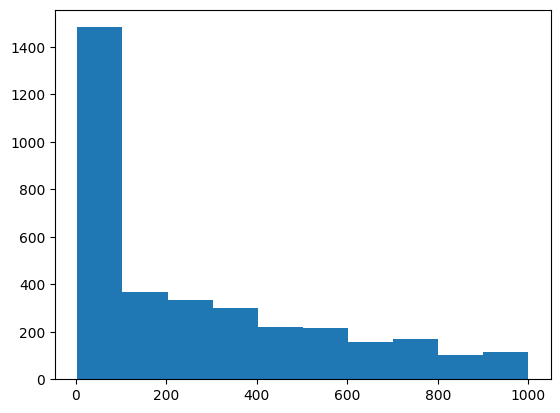

In [17]:
#plt.hist(mpv_p_matches['semantic_type'])
#plt.hist(mpv_p_matches['true_nu_id'])
#plt.hist(mpv_p_matches['true_EInit'])
plt.hist(mpv_p_matches['true_kinE'])

In [18]:
# Define plotting functions
def plot_confusion_matrix(cm, x,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         xlabel='Predicted label',
                         ylabel='True label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #xticklabels = ['HIP', 'MIP', 'Shower', 'Delta', 'Michel']

    xticklabels = ['Photon', '$e$', '$\mu$', '$\pi$', 'Proton']
    if cm.shape[1] > 5:
        xticklabels.append('Ghost')
    #     if cm.shape[1] > 5:
    #         xticklabels.append('Ghost')

    fig, ax = plt.subplots()
    print(cm.shape)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    #labels = ['HIP', 'MIP', 'Shower', 'Delta', 'Michel']
    labels = ['Photon', '$e$', '$\mu$', '$\pi$', 'Proton']
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=xticklabels, yticklabels=labels,
           title=title,
           ylabel=ylabel,
           xlabel=xlabel,
           ylim=(-0.5, cm.shape[0]-0.5))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            perc = str(format(cm[i,j],fmt))
            stat = str(format(x[i,j],fmt))
            ax.text(j, i, perc+'\n'+'('+stat+')',
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=15)
    fig.tight_layout()
    
    
    
    return ax

from numpy.linalg import norm

def confusion_matrix(kinematics, num_classes):
    x = np.zeros((num_classes, num_classes))
    for c in range(num_classes):
        for c2 in range(num_classes):
            x[c][c2] =  np.count_nonzero((kinematics['true_type'] == c) & (kinematics['pred_type'] == c2) )
        #x[c][-1] = np.nansum(metrics['num_true_pix_class%d' % c]-metrics['num_true_deghost_pix_class%d' % c])
    return x / x.sum(axis=1, keepdims=True), x

(5, 5)


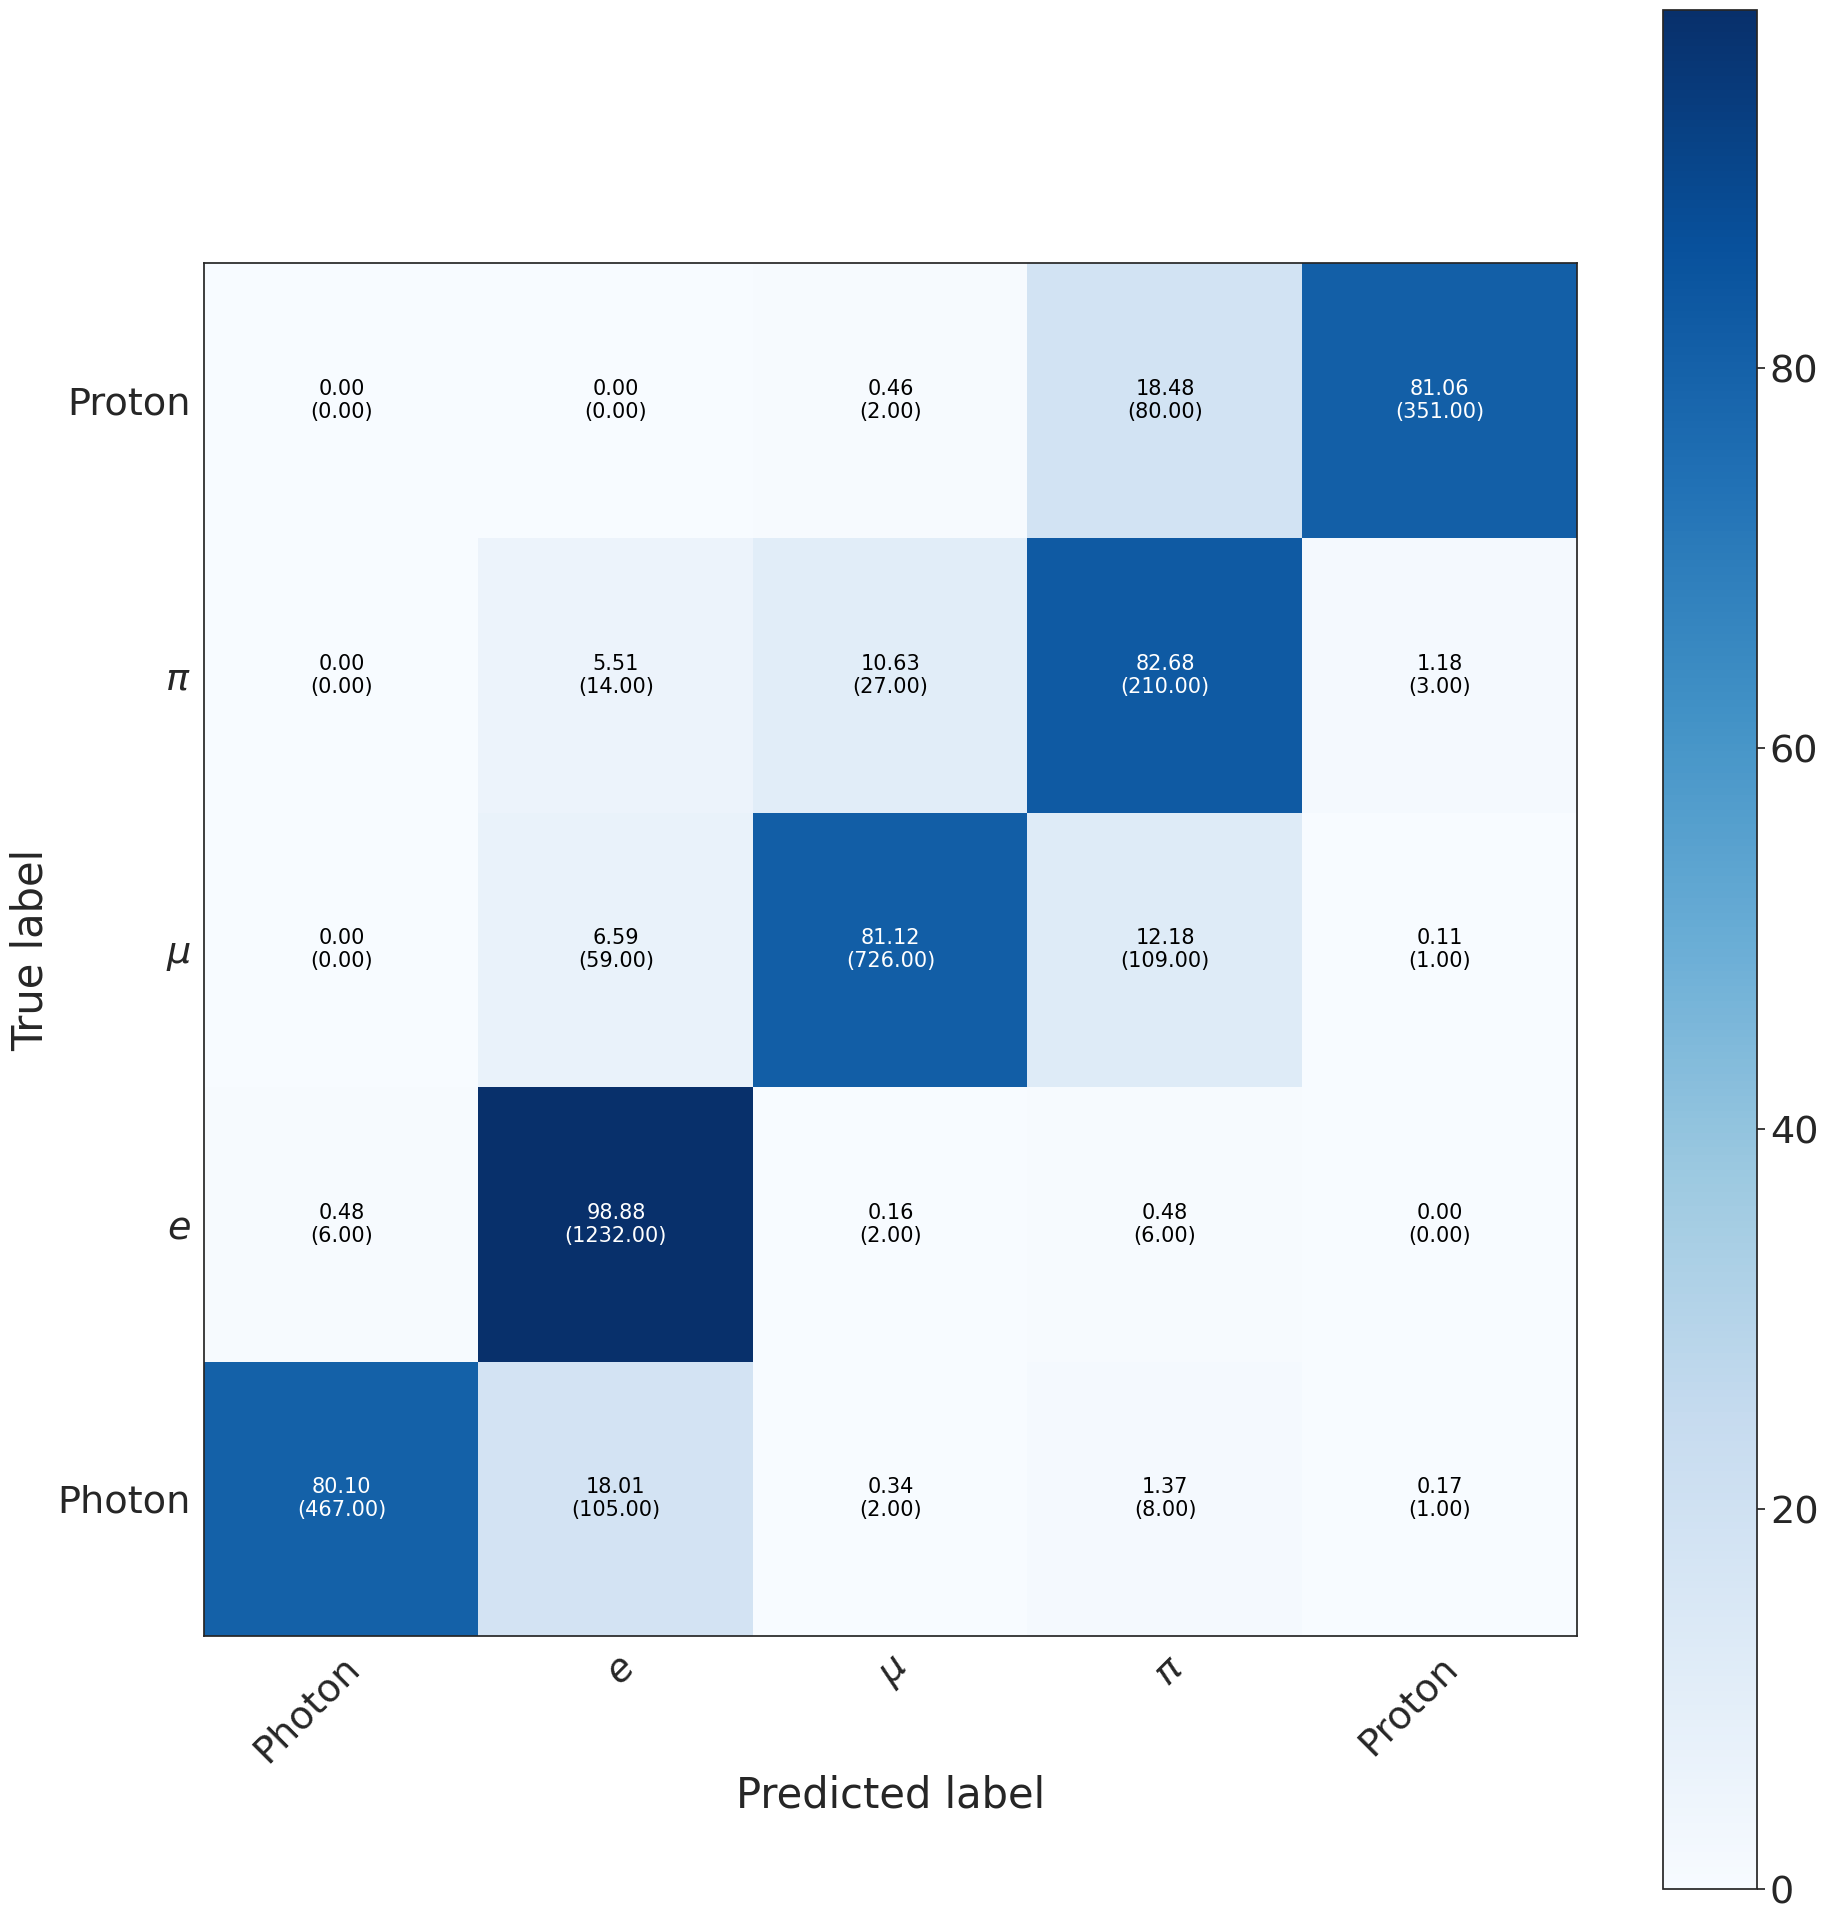

In [22]:
test_kinematics = mpv_p_matches

##################
seaborn.set(style="white", font_scale=2.5)

frac, x = confusion_matrix(test_kinematics, 5)
frac = np.array(frac*100)
x = np.array(x)

plot_confusion_matrix(frac, x)
#plt.savefig("confusion_matrix.png", transparent=True)
seaborn.set(rc={
    'figure.figsize':(200, 200),
})
seaborn.set_context('talk')
##################

### Exercise 2:
   
**mpv_p_matches** includes true_nu_id, primary_id, true_kinE, etc.

Can you create conditions to only look at MPV, primary particles?

What other constraints can you apply to make more insightful confusion matrices?


(5, 5)


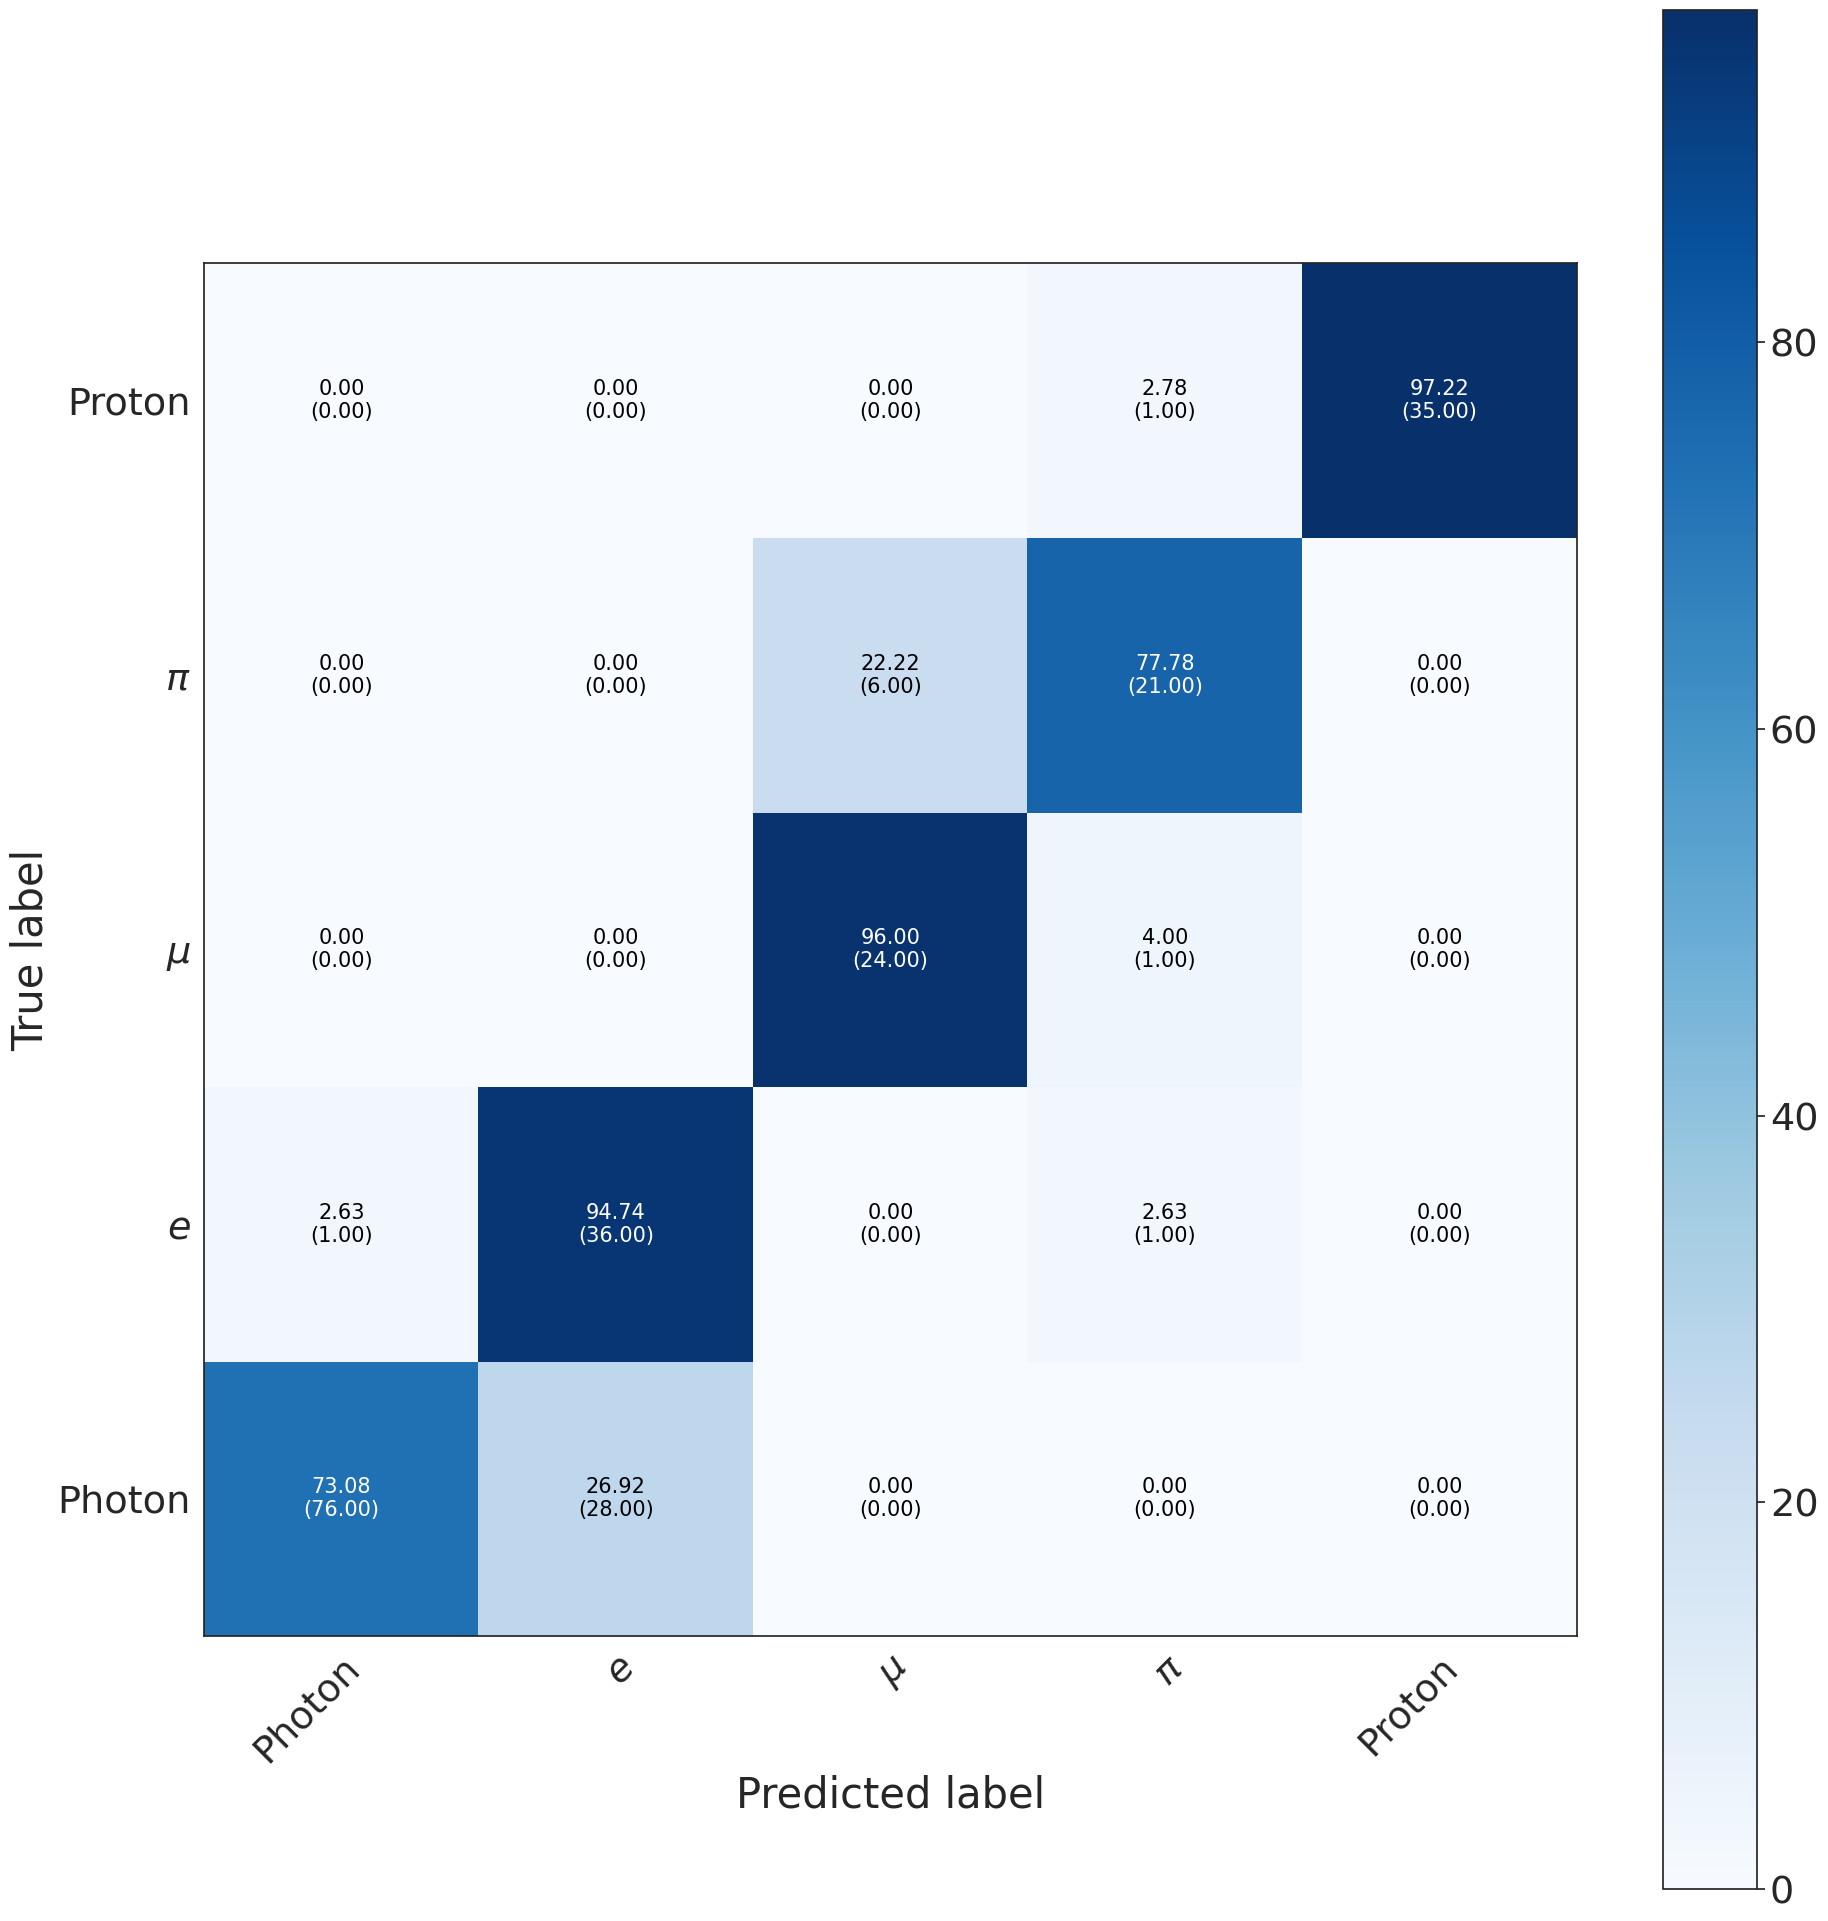

In [24]:
#test_kinematics = mpv_p_matches

cond_pri = mpv_p_matches['is_primary']==True
cond_mpv = mpv_p_matches['true_nu_id']==True

#cond_low_kinE = mpv_p_matches['true_kinE']<500
#cond_semantic_EM = mpv_p_matches['semantic_type'] == 0
#cond_semantic_deltas = mpv_p_matches['semantic_type'] == 2
#cond_semantic_michels = mpv_p_matches['semantic_type'] == 3 

test_kinematics = mpv_p_matches.where(cond_pri & cond_mpv)

##################
seaborn.set(style="white", font_scale=2.5)

frac, x = confusion_matrix(test_kinematics, 5)
frac = np.array(frac*100)
x = np.array(x)

plot_confusion_matrix(frac, x)
#plt.savefig("confusion_matrix.png", transparent=True)
seaborn.set(rc={
    'figure.figsize':(20, 20),
})
seaborn.set_context('talk')
##################

# 3. Interaction-level PID investigation

PID prediction is trained through the interaction GrapPA.

Here, we can study the correlation between interaction features and PID performance.

We will
 * Select true MPV interaction using `true_nu_id`, then find the matching reconstructed interaction. 
 * Define an error metric for interaction-wise PID performance.
 * Build interaction dataframe
 * Project the error metric on kinematic features (number of primaries, true kinetic energy).


# 3. 1. Selecting MPV interactions


Let's take a look at interactions in the dataset

In [47]:
# Get entry number #ENTRY_NUM from HDF5 (when reading from HDF5)
ENTRY_NUM = 1
data = driver.process(entry=ENTRY_NUM)

reco_interactions  = data['reco_interactions']
truth_interactions = data['truth_interactions']

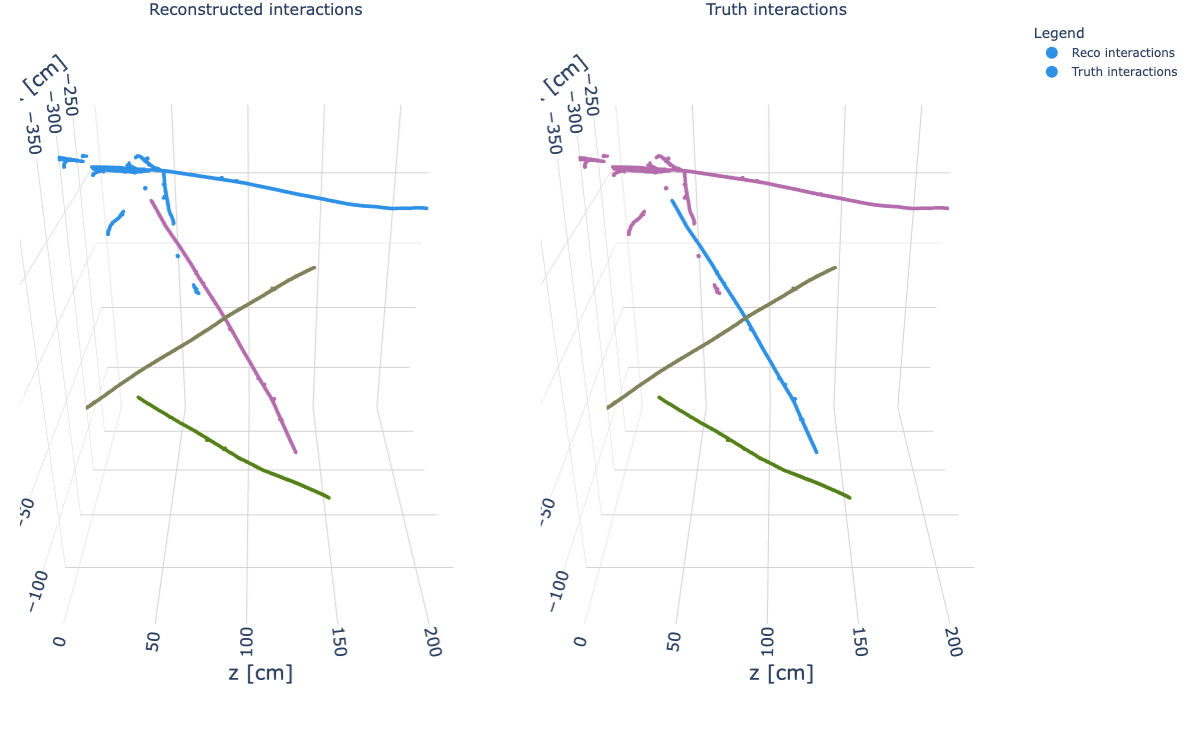

In [48]:
from spine.vis.layout import layout3d
from spine.vis.out import Drawer

# Example traces (3d scatterplots)
drawer = Drawer(data)

fig = drawer.get('interactions', 'id')

fig.show()

By this visual check:
    reco MPV interaction ID : 0, true MPV interaction ID : 1
    

In [69]:
# returns the list of reco. interaction ids matched to true interaction with ('true_nu_id'==1) in the batch

def matched_nu_int(driver):
    inter_id = []
    
    for ENTRY_NUM in tqdm(range(len(driver))):

        data = driver.process(entry=ENTRY_NUM)

        reco_interactions  = data['reco_interactions']
        truth_interactions = data['truth_interactions']

        interaction_matches = data['interaction_matches_t2r']
        for int_pair in interaction_matches:
            n_primary = len([p for p in int_pair[0].particles if p.is_primary])
            if (n_primary > 1):
                inter_id.append([ENTRY_NUM, int_pair[1].id])
                continue
                
    return inter_id    

In [70]:
mpv_interaction_id = matched_nu_int(driver)

100%|██████████| 256/256 [00:14<00:00, 18.27it/s]


In [71]:
print(np.shape(mpv_interaction_id))
print(mpv_interaction_id)

(250, 2)
[[0, 1], [1, 0], [2, 2], [3, 0], [4, 0], [5, 1], [6, 4], [7, 0], [8, 2], [9, 0], [10, 1], [11, 1], [12, 0], [13, 0], [14, 1], [15, 0], [16, 1], [17, 0], [18, 0], [19, 0], [20, 0], [21, 1], [22, 1], [22, 0], [23, 0], [24, 0], [25, 0], [26, 0], [27, 4], [28, 2], [29, 0], [30, 0], [31, 0], [32, 1], [33, 0], [34, 0], [35, 4], [36, 1], [37, 0], [38, 6], [39, 2], [40, 0], [41, 2], [42, 1], [43, 4], [44, 0], [45, 0], [46, 0], [47, 1], [48, 1], [49, 2], [50, 0], [51, 3], [52, 2], [53, 0], [54, 0], [55, 3], [56, 1], [58, 0], [59, 1], [61, 2], [62, 0], [63, 1], [64, 0], [65, 0], [66, 1], [67, 0], [68, 3], [69, 6], [70, 1], [71, 1], [72, 5], [73, 0], [74, 0], [75, 0], [76, 0], [77, 0], [78, 1], [79, 1], [80, 0], [81, 2], [82, 0], [83, 4], [84, 0], [85, 0], [86, 0], [87, 1], [88, 1], [89, 1], [90, 1], [91, 1], [92, 2], [93, 1], [95, 0], [96, 0], [97, 0], [98, 0], [99, 0], [100, 0], [101, 5], [102, 4], [103, 5], [104, 0], [105, 0], [106, 1], [107, 0], [108, 4], [109, 1], [110, 0], [111, 0]

## 3. 2. Per-interaction PID performance error

<figure>
<img src="PID_error_definition.png" style="width:70%">
<img src="PID_error_example.png" style="width:70%">
<figcaption align = "center"> </figcaption>
</figure>

In [72]:
def average_PID_error_demo(p_matches, entry_id, interaction_id):
    
    inter= p_matches[(p_matches['entry']==entry_id) & (p_matches['inter_id']==interaction_id)]
    #print (inter)
    
    average_error=0.
    error_sum = 0.
    #print(len(inter))
    if (len(inter)<1.):
        return -1.
    for idx, particle in inter.iterrows():
        
        class_prediction = particle['pid_scores'][int(particle['true_type'])]

        error_sum+=1.-class_prediction
        #print("{:2}".format(particle['pid_scores']))
        print("true PID: ", particle['true_type'], ", PID pred: ", particle['pid_scores'], ", Prediction_error: ", "{:.3f}".format(1-class_prediction), ", Error_sum: ", "{:.3f}".format(error_sum))
        #print("\n")
        
    average_error=error_sum/len(inter)
    print("Average error : ", average_error)

    return average_error
    

In [73]:
mpv_p_matches[mpv_p_matches['entry']==1]

,pred_type,pid_scores,is_primary,inter_id,depo_sum,semantic_type,true_type,true_nu_id,true_EDepo,true_EInit,true_primary,true_inter_id,true_kinE,entry
0,0,"[0.9981364, 0.0018635802, 0.0, 0.0, 0.0]",1,0,91.365265,0,0,0,82.102577,366.823149,1,1,366.823149,1
1,0,"[0.9984466, 0.0015534074, 0.0, 0.0, 0.0]",1,0,139.904343,0,0,0,138.019150,239.033156,1,1,239.033156,1
2,0,"[0.9901211, 0.009878843, 0.0, 0.0, 0.0]",1,0,48.510227,0,0,0,47.297581,59.121988,1,1,59.121988,1
3,0,"[0.9936456, 0.006354421, 0.0, 0.0, 0.0]",1,0,105.317352,0,0,0,74.796349,133.501134,1,1,133.501134,1
4,1,"[0.43663964, 0.5633604, 0.0, 0.0, 0.0]",1,0,6.268635,0,0,0,47.297581,59.121988,1,1,59.121988,1
5,1,"[0.0835806, 0.9164194, 0.0, 0.0, 0.0]",1,0,134.469833,0,1,0,111.006760,180.015843,1,1,179.505416,1
6,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",0,0,18.023792,2,0,0,138.019150,239.033156,1,1,239.033156,1
7,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",0,2,8.066105,3,1,-1,10.944256,13.085626,0,2,12.574622,1
8,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",0,1,2.514080,3,1,-1,5.000135,8.425678,0,0,7.914675,1
9,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",0,3,5.698081,3,1,-1,6.983006,8.916564,0,3,8.405566,1


In [74]:
average_PID_error_demo(mpv_p_matches, entry_id=1, interaction_id=1)

true PID:  1 , PID pred:  [0. 1. 0. 0. 0.] , Prediction_error:  0.000 , Error_sum:  0.000
true PID:  1 , PID pred:  [0. 1. 0. 0. 0.] , Prediction_error:  0.000 , Error_sum:  0.000
true PID:  1 , PID pred:  [0. 1. 0. 0. 0.] , Prediction_error:  0.000 , Error_sum:  0.000
true PID:  1 , PID pred:  [0. 1. 0. 0. 0.] , Prediction_error:  0.000 , Error_sum:  0.000
true PID:  1 , PID pred:  [0. 1. 0. 0. 0.] , Prediction_error:  0.000 , Error_sum:  0.000
true PID:  1 , PID pred:  [0. 1. 0. 0. 0.] , Prediction_error:  0.000 , Error_sum:  0.000
true PID:  1 , PID pred:  [0. 1. 0. 0. 0.] , Prediction_error:  0.000 , Error_sum:  0.000
true PID:  2 , PID pred:  [0.000000e+00 0.000000e+00 9.399860e-01 5.997459e-02 3.944769e-05] , Prediction_error:  0.060 , Error_sum:  0.060
Average error :  0.007501751184463501


0.007501751184463501

## 3. 3. Building interaction information from particle information

In [75]:
# Fill interaction dataframe

from tqdm import tqdm

def build_inter(p_matches, interaction_id):

    inter_matches = {
        "entry" : [],
        "mul" : [],
        "pri_mul": [],
        "pid_error": [],
        "pri_pid_error": [],
        "true_EInit": [],
        "pri_true_EInit": [],
        "true_kinE": [],
        "pri_true_kinE": [],
        "true_pri_num_p": [],
        "true_pri_num_mu": [],
        "reco_pri_num_p": [],
        "reco_pri_num_mu": [],
        
    }

    for IMAGE_IDX in tqdm(range(len(interaction_id))):
    
    
        cond = p_matches['entry']==IMAGE_IDX #image index condition
    
        total_E = 0.
        kin_E = 0.
        total_num = 0
        pid_error = 0.
        pri_E = 0.
        pri_kin_E = 0.
        pri_num = 0
        pri_pid_error = 0.
        true_pri_num_p = 0.
        true_pri_num_mu = 0.
        reco_pri_num_p = 0.
        reco_pri_num_mu = 0.
        
        # Masking using image index condition
        for index, row in p_matches.where(cond).iterrows():
        
            # true_NU_ID condition
            # interaction_id is pre-obtained by truth_interactions & interactions matching
            if row['inter_id'] == interaction_id[IMAGE_IDX][1]:
                #print(row['entry'], row['pid_scores'])
                total_num += 1
                total_E += row['true_EInit']
                kin_E += row['true_kinE']
                pid_error += 1-row['pid_scores'][int(row['pred_type'])]
            
                if row['true_primary']:
                    pri_num += 1
                    pri_E += row['true_EInit']
                    pri_kin_E += row['true_kinE']
                    pri_pid_error += 1-row['pid_scores'][int(row['pred_type'])]
                    
                    if (row['true_type']==2):
                        true_pri_num_mu+=1
                    elif (row['true_type']==4):
                        true_pri_num_p+=1
                        
                    if (row['pred_type']==2):
                        reco_pri_num_mu+=1
                    elif (row['pred_type']==4):
                        reco_pri_num_p+=1
        
        inter_matches["entry"].append(IMAGE_IDX)
        inter_matches["mul"].append(total_num)
        inter_matches["true_EInit"].append(total_E/1000.)
        inter_matches["true_kinE"].append(kin_E/1000.)
        if(total_num>0):
            inter_matches["pid_error"].append(pid_error/total_num)
        else:
            inter_matches["pid_error"].append(-1.)
        inter_matches["pri_mul"].append(pri_num)
        inter_matches["pri_true_EInit"].append(pri_E/1000.)
        inter_matches["pri_true_kinE"].append(pri_kin_E/1000.)
        if(pri_num>0):
            inter_matches["pri_pid_error"].append(pri_pid_error/pri_num)
        else:
            inter_matches["pri_pid_error"].append(-1.)
        inter_matches["true_pri_num_p"].append(true_pri_num_p)
        inter_matches["true_pri_num_mu"].append(true_pri_num_mu)
        inter_matches["reco_pri_num_p"].append(reco_pri_num_p)
        inter_matches["reco_pri_num_mu"].append(reco_pri_num_mu)
    
    inter_matches = pd.DataFrame.from_dict(inter_matches)
    return inter_matches

#print(inter_matches)

In [76]:
mpv_inter = build_inter(mpv_p_matches, mpv_interaction_id)

100%|██████████| 250/250 [00:33<00:00,  7.53it/s]


In [78]:
mpv_inter

,entry,mul,pri_mul,pid_error,pri_pid_error,true_EInit,pri_true_EInit,true_kinE,pri_true_kinE,true_pri_num_p,true_pri_num_mu,reco_pri_num_p,reco_pri_num_mu
0,0,7,5,0.035616,0.049776,3.494363,3.073675,1.925553,1.644946,1.0,2.0,2.0,1.0
1,1,10,9,0.056646,0.062940,3.113811,3.104169,2.068859,2.059729,1.0,1.0,1.0,1.0
2,2,3,2,0.012533,0.018799,1.560803,1.548185,0.516362,0.504255,1.0,1.0,1.0,1.0
3,3,10,6,0.116288,0.158071,5.559050,4.442486,3.156604,2.979846,1.0,1.0,1.0,1.0
4,4,3,3,0.200324,0.200324,1.094273,1.094273,1.094273,1.094273,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,2,1,0.003397,0.006793,0.537582,0.489237,0.431413,0.383579,0.0,1.0,0.0,1.0
246,246,1,1,0.390929,0.390929,0.540442,0.540442,0.540442,0.540442,0.0,0.0,0.0,0.0
247,247,1,1,0.167070,0.167070,0.582486,0.582486,0.581983,0.581983,0.0,0.0,0.0,0.0
248,248,5,1,0.006201,0.031007,0.968040,0.925288,0.860338,0.819630,0.0,1.0,0.0,1.0


-0.06858309079782357


(array([111.,  39.,  32.,  17.,   7.,   1.,   0.,   0.,   0.,   0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

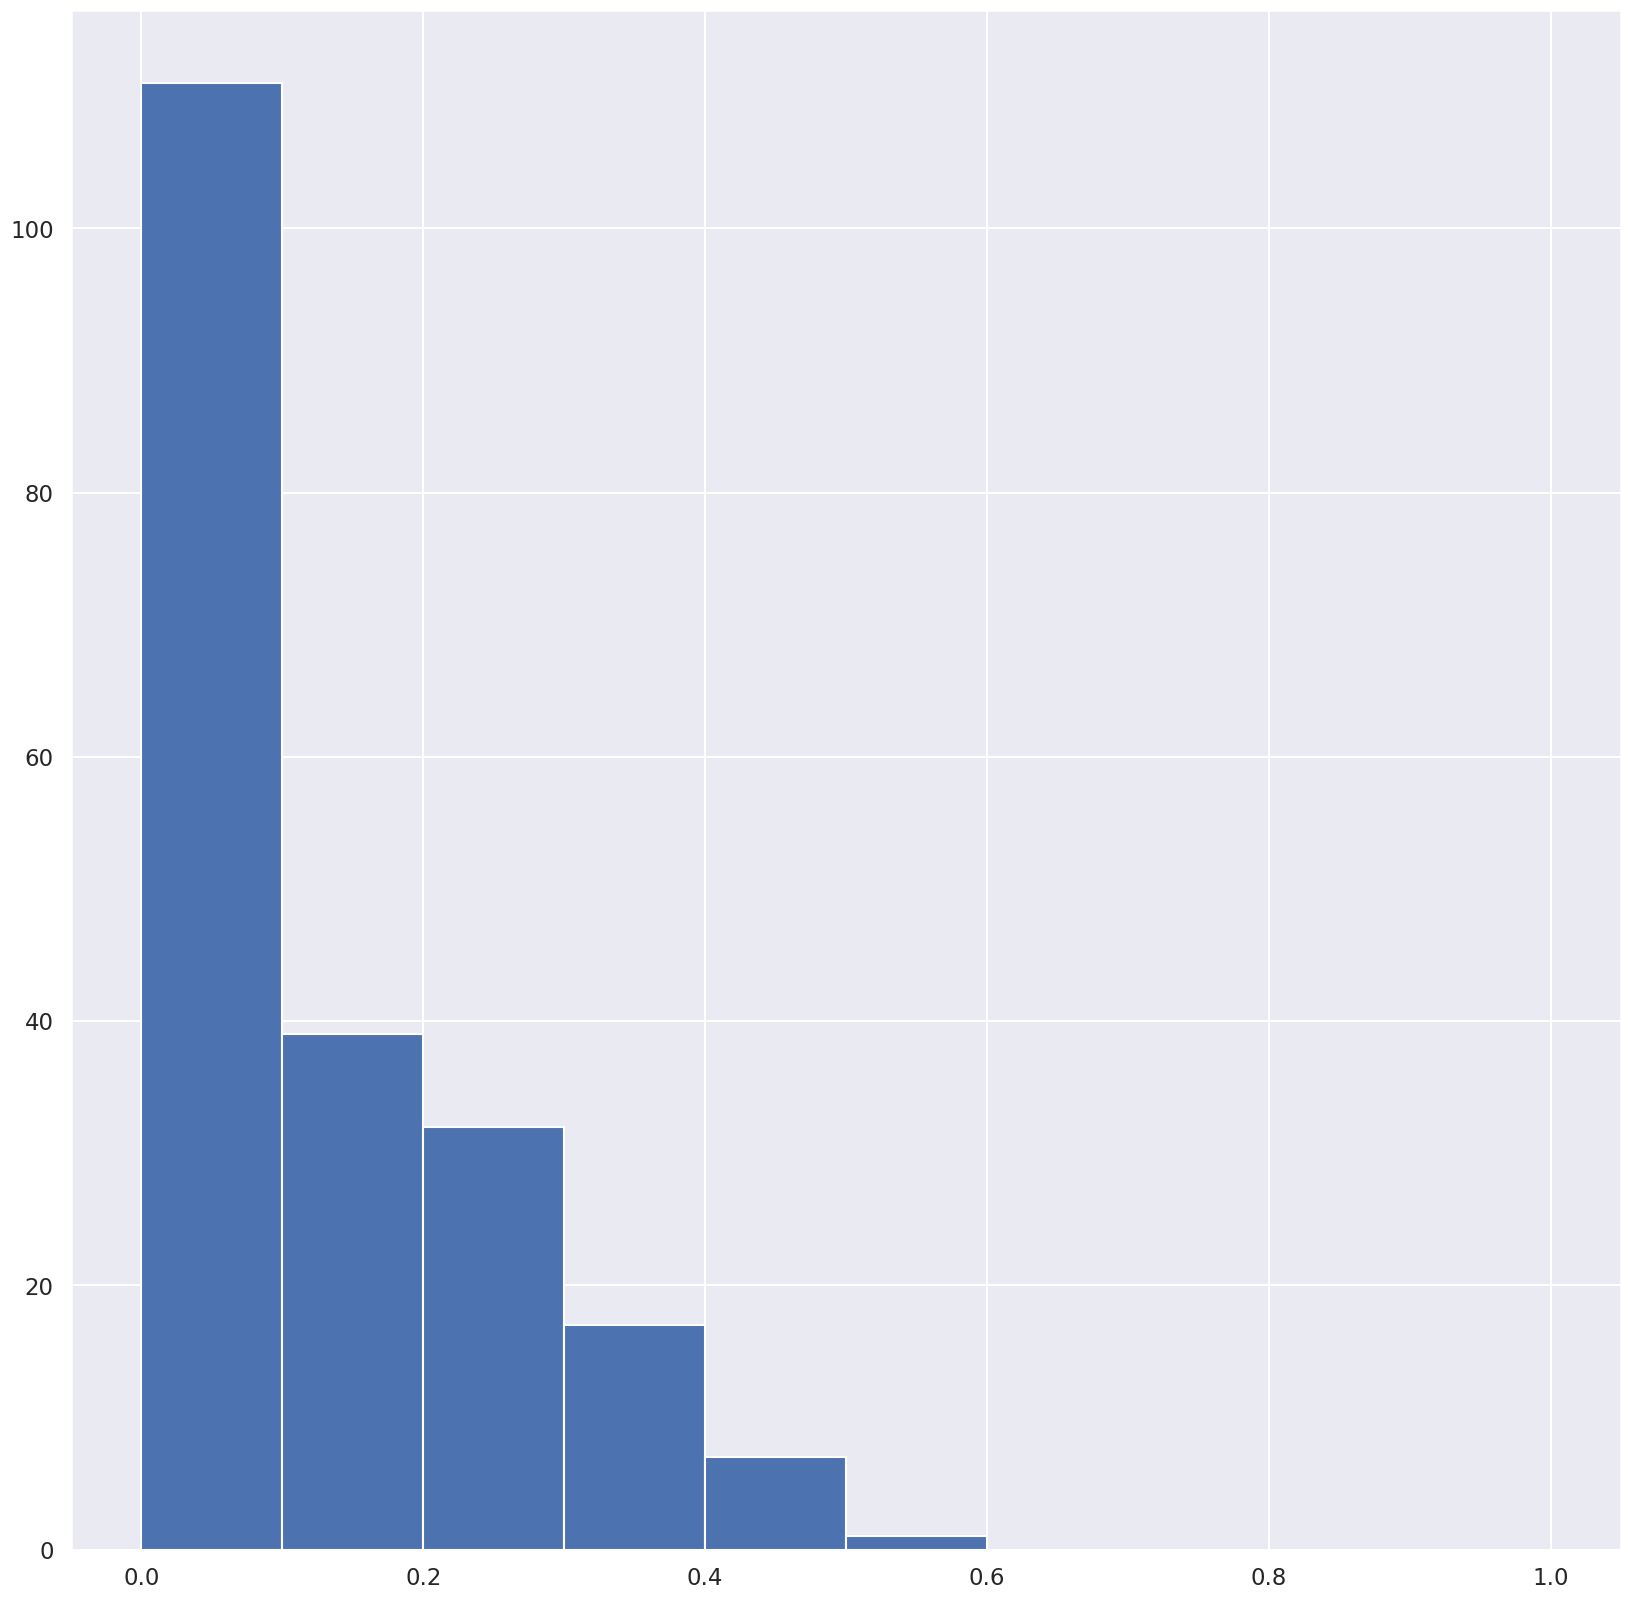

In [80]:
print(np.mean(mpv_inter['pri_pid_error']))
plt.hist(mpv_inter['pri_pid_error'], range=[0,1])

In [81]:
# definining interaction plotting function

from matplotlib.colors import LogNorm

def interaction_plot(x1, y1, xbins, ybins, x_label, y_label, title):
    f, ax1 = plt.subplots()
    f.set_figheight(5)
    f.set_figwidth(5)
    xbins=xbins
    ybins=ybins

    # bin witdh
    xbinw = float(xbins[1]-xbins[0])

    # mpv
    y1 = np.asarray(y1)
    x1 = np.asarray(x1)

    ax1.hist2d(x1,y1, bins=[xbins, ybins],cmap='GnBu', norm=LogNorm())
    #ax1.set_title('Sharing Y axis')
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)
    ax1.set_title(title)

    # getting the mean and RMS values of each vertical slice of the 2D distribution
    x1_slice_mean, x1_slice_rms = [], []
    for i,b in enumerate(xbins[:-1]):
        #print(i,b)
        #print(y1[ (x1>=xbins[i]) & (x1<xbins[i+1]) ].mean())
        x1_slice_mean.append( y1[ (x1>=xbins[i]) & (x1<xbins[i+1]) ].mean())
        x1_slice_rms.append( y1[ (x1>=xbins[i]) & (x1<xbins[i+1]) ].std())
    
    x1_slice_mean = np.array(x1_slice_mean)
    x1_slice_rms = np.array(x1_slice_rms)

    xbinw = float(xbins[1]-xbins[0])
    ax1.errorbar(xbins[:-1]+ xbinw/2, x1_slice_mean, x1_slice_rms,fmt='_', ecolor='k', color='k')

    h = ax1.hist2d(x1,y1, bins=[xbins, ybins],cmap='GnBu', norm=LogNorm())
    f.subplots_adjust(right=0.9)
    cbar_ax = f.add_axes([0.95, 0.1, 0.05, 0.8])


    f.colorbar(h[3], ax=ax1,cax=cbar_ax)
    #f.savefig('MPV_1mu2p_primaryID_error_lowE.png', dpi=500)
    return f
    #f.show()

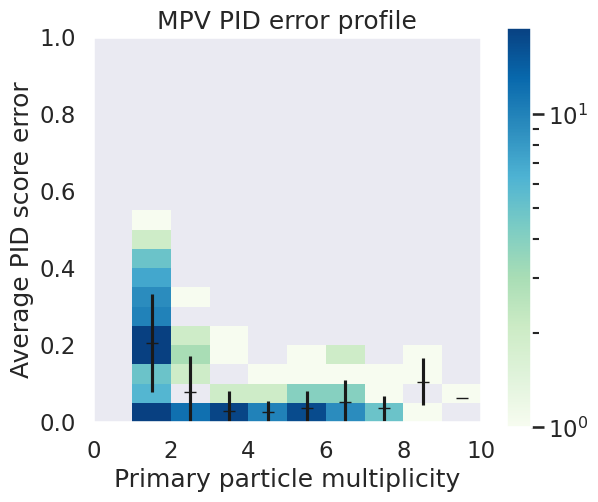

In [82]:
f = interaction_plot(mpv_inter['pri_mul'], mpv_inter['pri_pid_error'], xbins=np.linspace(0.,10.,11), ybins=np.linspace(0,1,21), x_label='Primary particle multiplicity', y_label='Average PID score error', title='MPV PID error profile')

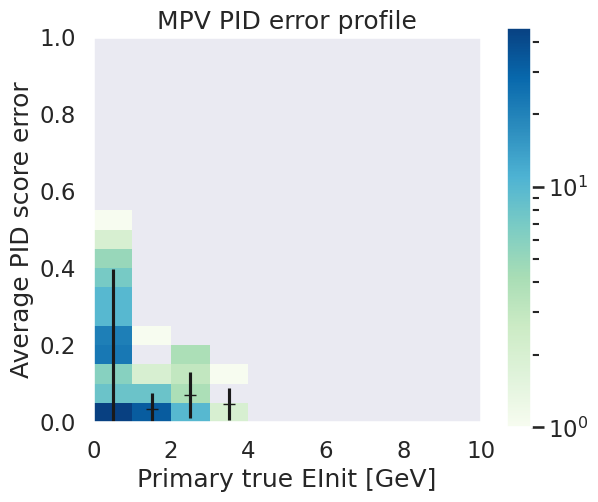

In [83]:
f = interaction_plot(mpv_inter['pri_true_kinE'], mpv_inter['pri_pid_error'], xbins=np.linspace(0.,10.,11), ybins=np.linspace(0,1,21), x_label='Primary true EInit [GeV]', y_label='Average PID score error', title='MPV PID error profile')

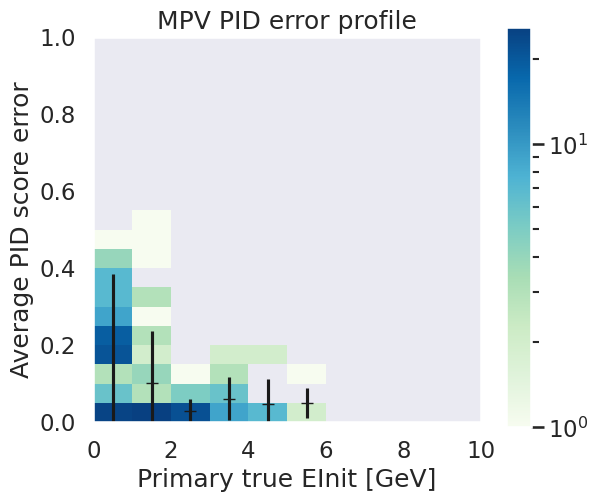

In [84]:
f = interaction_plot(mpv_inter['pri_true_EInit'], mpv_inter['pri_pid_error'], xbins=np.linspace(0.,10.,11), ybins=np.linspace(0,1,21), x_label='Primary true EInit [GeV]', y_label='Average PID score error', title='MPV PID error profile')

## Exercises
 * Save particles, interactions info. to csv.
 * High stat analysis
 * Apply topology condition